<a href="https://colab.research.google.com/github/FGalvao77/Previsao-de-precos-de-imoveis-com-Apache-Spark/blob/main/Previs%C3%A3o_de_pre%C3%A7os_de_im%C3%B3veis_com_Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Previsão de preços de imóveis com Apache Spark**

---



Utilizando o ambiente do `Google Colab`, vamos explorar a **API** do spark para _Python_, o `Pyspark`, e da biblioteca de _Machine Learning_, `MLlib`, para realizar a análise exploratória de um conjunto de dados e fazer uma _Regressão Linear_.

O desafio é prever preços de imóveis, para esse problema utilizaremos o dataset [California Housing Prices](https://raw.githubusercontent.com/FGalvao77/datasets/main/cal_housing.data), é claro, que esse conjunto de dados é "pequeno" para o contexto de utilização do Spark, que tem como intuito de fornecer as ferramentas necessárias para análise de conjunto de dados muito maiores, o chamado `Big Data`. Mas o principal objetivo é explorar o Spark de forma didática e construir um modelo de aprendizado de máquina.

### **1. Conhecendo o conjunto de dados**

O conjunto de dados `California Housing` apareceu em um artigo de 1997 intitulado _Sparse Spatial Autoregressions_, escrito por Pace, R. Kelley e Ronald Barry e publicado no jornal **Statistics and Probability Letters**. Os pesquisadores construíram esse conjunto de dados usando os dados do censo de 1990 da Califórnia.

Os dados contêm uma linha por grupo de blocos do censo. Um grupo de quarteirões é a menor unidade geográfica para a qual o _U.S. Census Bureau_ publica dados de amostra (um grupo de quarteirões normalmente tem uma população de 600 a 3.000 pessoas). Nesta amostra, um grupo de quarteirões em média inclui 1425,5 indivíduos que vivem em uma área geograficamente compacta.

Esses dados espaciais contêm 20.640 observações sobre os preços da habitação com 9 variáveis ​​econômicas:

- `longitude`: medida de quão longe a oeste está uma casa; um valor mais alto está mais a oeste;
- `latitude`: medida de quão distante ao norte está uma casa; um valor mais alto está mais ao norte;
- `housingMedianAge`: idade média de uma casa dentro de um quarteirão; um número menor é um prédio mais novo;
- `totalRooms`: número total de quartos em um bloco;
- `totalBedrooms`: número total de quartos nas casas por grupo de blocos;
- `population`: número total de pessoas que residem em um bloco;
- `households`: número total de domicílios, um grupo de pessoas que residem em uma unidade domiciliar, para um bloco;
- `medianIncome`: renda média para famílias dentro de um bloco de casas (medida em dezenas de milhares de dólares americanos) e,
- `medianHouseValue`: Valor médio da casa para famílias dentro de um quarteirão (medido em dólares americanos).


_**Obs.:**_ Encontramos outras bases de dados que possuem também o atributo `oceanProximity` que se refere o quanto a casa está próximo do mar.

Porém nesse estudo, esse atributo não faz parte da base de dados utilizada para esse desafio.

O atributo `medianHouseValue` (mediana do valor da casa) é a variável dependente e será atribuído o papel da variável alvo (target) em nosso modelo de Machine Learning.

### **2. Instalando o `PySpark`, suas dependências e configurando as variáveis de ambiente**

In [1]:
# instalando o pyspark
!pip install pyspark

     |████████████████████████████████| 212.4 MB 64 kB/s 
     |████████████████████████████████| 198 kB 55.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=d4beb2f332fe1ba6cba9845333528da5375f598267cb113ce8a942c4d3fda898
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [2]:
# instalando as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark

In [3]:
# configurando as variáveis de ambiente
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'

# tornando o pyspark "importável"
import findspark
# findspark.init()
findspark.init('spark-3.1.2-bin-hadoop2.7')

### **3. Instalando as bibliotecas e funções necessárias e, configurando o parâmetros para visualização gráfica**

In [4]:
# importando as bibliotecas e funções
# import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# configurando os parâmetros para visualização gráfica
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# configurando a semente aleatória para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

### **4. Iniciando uma SparkSession**

De início é necessário criar uma sessão Spark, onde é possível configurar os nós do cluster, bem como a memória alocada para cada um deles.

Para essa nossa atividade usaremos uma confuguração mínima da sessão.

In [7]:
# importando a biblioteca para iniciar uma sessão spark
from pyspark.sql import SparkSession

# iniciando uma sessão spark - usamos quando se trabalha com dataframes no spark
spark = SparkSession.builder\
        .master('local[*]')\
        .appName('Linear Regression Model with PySpark/MLlib - dataset California Housing')\
        .getOrCreate()

# visualizando a sessão criada e sua configurações 
spark

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Linear Regression Model with PySpark/MLlib - dataset California Housing>

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

### **5. Importando e carregando o conjunto de dados**

In [225]:
# realizando o download do https para arquivo local
!wget --quiet --show-progress https://raw.githubusercontent.com/FGalvao77/datasets/main/cal_housing.data

cal_housing.data.1  100%[===================>]   1.97M  --.-KB/s    in 0.01s   


In [226]:
# instanciando o caminho do arrquivo na variável "DATA"
DATA = '/content/cal_housing.data'

In [227]:
# carregando os dados
df = spark.read.csv(path=DATA)

### **6. Análise exploratória dos dados**

In [228]:
# visualizando o conjunto de dados
df.take(2)

[Row(_c0='-122.230000', _c1='37.880000', _c2='41.000000', _c3='880.000000', _c4='129.000000', _c5='322.000000', _c6='126.000000', _c7='8.325200', _c8='452600.000000'),
 Row(_c0='-122.220000', _c1='37.860000', _c2='21.000000', _c3='7099.000000', _c4='1106.000000', _c5='2401.000000', _c6='1138.000000', _c7='8.301400', _c8='358500.000000')]

In [229]:
# visualizando o conjunto de dados em forma de tabela
df.show(5)  # 5 primeiras linhas

+-----------+---------+---------+-----------+-----------+-----------+-----------+--------+-------------+
|        _c0|      _c1|      _c2|        _c3|        _c4|        _c5|        _c6|     _c7|          _c8|
+-----------+---------+---------+-----------+-----------+-----------+-----------+--------+-------------+
|-122.230000|37.880000|41.000000| 880.000000| 129.000000| 322.000000| 126.000000|8.325200|452600.000000|
|-122.220000|37.860000|21.000000|7099.000000|1106.000000|2401.000000|1138.000000|8.301400|358500.000000|
|-122.240000|37.850000|52.000000|1467.000000| 190.000000| 496.000000| 177.000000|7.257400|352100.000000|
|-122.250000|37.850000|52.000000|1274.000000| 235.000000| 558.000000| 219.000000|5.643100|341300.000000|
|-122.250000|37.850000|52.000000|1627.000000| 280.000000| 565.000000| 259.000000|3.846200|342200.000000|
+-----------+---------+---------+-----------+-----------+-----------+-----------+--------+-------------+
only showing top 5 rows



In [143]:
# # visualizando as instâncias únicas da coluna "ocProx"
# df.select('_c9').distinct().show()

> Irei excluir essa coluna da análise.

In [230]:
# visualizando o nome das colunas
df.columns

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8']

> Perceba que, o conjunto de dados não possui a descrição das colunas - seu `header`.

E pra facilitar nossas manipulações e visualizações irei instanciar os cabeçalhos.

Antes vamos olhar que tipo de dados há nas colunas.

In [231]:
# visualizando o tipo de dados das colunas
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)



> Como já é de conhecimento o que dados representam, relatado acima no tópico "`1. Conhecendo o conjunto de dados`", as colunas possuem valores numéricos contínuos.

Portanto de forma intuitiva irei declarar as colunas numéricas como sendo do tipo de ponto flutuante (`float`).

Primeiro vamos conhecer o tipo de dados no `Spark`.

In [232]:
# visualizando os tipos de dados no pyspark.sql
from pyspark.sql import types   # importando a biblioteca 

# visualizando os tipos de dados
for t in ['BinaryType', 'BooleanType', 'ByteType', 'DateType', 
          'DecimalType', 'DoubleType', 'FloatType', 'IntegerType', 
           'LongType', 'ShortType', 'StringType', 'TimestampType']:
    print(f"{t}: {getattr(types, t)().simpleString()}")

BinaryType: binary
BooleanType: boolean
ByteType: tinyint
DateType: date
DecimalType: decimal(10,0)
DoubleType: double
FloatType: float
IntegerType: int
LongType: bigint
ShortType: smallint
StringType: string
TimestampType: timestamp


> Vamos realizar um pré tratamento dos dados:
- iremos transformar o tipo de dados das colunas com dados do tipo `string` para `float`.

In [233]:
# função para converter o tipo de dados das colunas
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

In [153]:
# # com a função ".drop()" eliminaremos a coluna "_c9"
# df = df.drop('_c9')
# df.columns

In [234]:
# atribuindo todos os nomes das colunas a `cols`
cols = df.columns  

# visualizando as colunas selecionadas
cols

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8']

In [235]:
# utilizando a função e convertendo as colunas `df` em` FloatType() e,
# instanciando em uma nova variável "housing_df"
housing_df = convertColumn(df, cols, FloatType())

In [236]:
# conferindo se a conversão ocorreu conforme planejado
housing_df.printSchema()

root
 |-- _c0: float (nullable = true)
 |-- _c1: float (nullable = true)
 |-- _c2: float (nullable = true)
 |-- _c3: float (nullable = true)
 |-- _c4: float (nullable = true)
 |-- _c5: float (nullable = true)
 |-- _c6: float (nullable = true)
 |-- _c7: float (nullable = true)
 |-- _c8: float (nullable = true)



> Tipo de dados foi modificado com sucesso! :  )

Porém há um detalhe, o nome das colunas não está nada intuitiva. Vamos resolver esse problema agora!!!!

Irei declarar um esquema (`schema`) definido toda estrutura do conjunto de dados, ou seja, o nome das colunas e, manteremos o tipo de dados como sendo _float_.

In [237]:
# declarando a estrutura dos dados
schema = StructType([
                     StructField('longitude', FloatType(), nullable=True),
                     StructField('latitude', FloatType(), nullable=True),
                     StructField('housing_median_age', FloatType(), nullable=True),
                     StructField('total_rooms', FloatType(), nullable=True),
                     StructField('total_bedrooms', FloatType(), nullable=True),
                     StructField('population', FloatType(), nullable=True),
                     StructField('households', FloatType(), nullable=True),
                     StructField('median_income', FloatType(), nullable=True),
                     StructField('median_house_value', FloatType(), nullable=True)]
                    )

In [238]:
# carregando  novamente os dados e, passando como argumento o "schema"
df = spark.read.csv(path=DATA, schema=schema)

In [239]:
# instanciando os dados em uma nova variável e gerando um RDD (Resilient Distributed Dataset)
housing_df = df
housing_df.cache()   # definindo que, todo processamento dos dados será executado na memória cache

DataFrame[longitude: float, latitude: float, housing_median_age: float, total_rooms: float, total_bedrooms: float, population: float, households: float, median_income: float, median_house_value: float]

In [240]:
# visualizando o tipo do objeto da variável "df"
type (housing_df)

pyspark.sql.dataframe.DataFrame

In [241]:
# visualizando a quantidade de linhas
housing_df.count()

20640

In [242]:
# nome das colunas
housing_df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [243]:
# visualizando as 5 primeiras linhas
housing_df.take(5)

[Row(longitude=-122.2300033569336, latitude=37.880001068115234, housing_median_age=41.0, total_rooms=880.0, total_bedrooms=129.0, population=322.0, households=126.0, median_income=8.325200080871582, median_house_value=452600.0),
 Row(longitude=-122.22000122070312, latitude=37.86000061035156, housing_median_age=21.0, total_rooms=7099.0, total_bedrooms=1106.0, population=2401.0, households=1138.0, median_income=8.301400184631348, median_house_value=358500.0),
 Row(longitude=-122.23999786376953, latitude=37.849998474121094, housing_median_age=52.0, total_rooms=1467.0, total_bedrooms=190.0, population=496.0, households=177.0, median_income=7.257400035858154, median_house_value=352100.0),
 Row(longitude=-122.25, latitude=37.849998474121094, housing_median_age=52.0, total_rooms=1274.0, total_bedrooms=235.0, population=558.0, households=219.0, median_income=5.643099784851074, median_house_value=341300.0),
 Row(longitude=-122.25, latitude=37.849998474121094, housing_median_age=52.0, total_room

In [244]:
# visualizando o conjunto de dados em formato de tabela
housing_df.show()    # por padrão é exibido as 20 primeiras linhas

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|
|  -122.25|   37.85|              52.0|     1627.0|         280.0|     565.0|     259.0|       3.8462|          342200.0|
|  -122.25|   37.85|    

In [245]:
# visualizando informações sobre os tipos de dados de cada coluna
housing_df.printSchema()

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: float (nullable = true)



**Agora vamos renomear as colunas, deixando-as mais "enxuta" a sua descrição.**

In [246]:
# criando uma função para otimizar a renomeação das colunas
def renameCols(df, old_columns, new_columns):
    for old_cols, new_cols in zip(old_columns, new_columns):
        df = df.withColumnRenamed(old_cols, new_cols)
    return df

In [247]:
# instanciando a colunas atuais e o novos nome das colunas
old_cols = housing_df.columns
new_cols = ['long', 'lat', 'medAge', 'totRms', 'totBedRms', 
            'pop', 'housHlds', 'medInc', 'medHval']

In [248]:
# perceba que, os dois tipo de objeto são listas e do mesmo tamanho
type (old_cols), len(old_cols), type (new_cols), len(new_cols)

(list, 9, list, 9)

In [249]:
# aplicando a função no conjunto de dados e sobreescrevendo a variável "dfRDD"
housing_df = renameCols(housing_df, old_cols, new_cols)

In [250]:
# visualizando 2 primeiras linhas
housing_df.show(2)

+-------+-----+------+------+---------+------+--------+------+--------+
|   long|  lat|medAge|totRms|totBedRms|   pop|housHlds|medInc| medHval|
+-------+-----+------+------+---------+------+--------+------+--------+
|-122.23|37.88|  41.0| 880.0|    129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|7099.0|   1106.0|2401.0|  1138.0|8.3014|358500.0|
+-------+-----+------+------+---------+------+--------+------+--------+
only showing top 2 rows



In [251]:
# visualizando o tipo de dado das colunas
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medAge: float (nullable = true)
 |-- totRms: float (nullable = true)
 |-- totBedRms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- housHlds: float (nullable = true)
 |-- medInc: float (nullable = true)
 |-- medHval: float (nullable = true)



In [252]:
# verificando se há valores ausentes ("NaN")
housing_df.select([F.count(F.when(F.isnan(c), c)).
                   alias(c) for c in housing_df.
                   columns]).show()

+----+---+------+------+---------+---+--------+------+-------+
|long|lat|medAge|totRms|totBedRms|pop|housHlds|medInc|medHval|
+----+---+------+------+---------+---+--------+------+-------+
|   0|  0|     0|     0|        0|  0|       0|     0|      0|
+----+---+------+------+---------+---+--------+------+-------+



In [253]:
# selecionando as colunas de interesse e sobreescrevendo a variável
housing_df = housing_df.select('long', 'lat', 'medAge', 'totRms', 'totBedRms', 
                               'pop', 'housHlds', 'medInc', 'medHval')

In [254]:
# visualizando as 5 primeiras instâncias após a seleção das colunas de interesse
housing_df.show(5)

+-------+-----+------+------+---------+------+--------+------+--------+
|   long|  lat|medAge|totRms|totBedRms|   pop|housHlds|medInc| medHval|
+-------+-----+------+------+---------+------+--------+------+--------+
|-122.23|37.88|  41.0| 880.0|    129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|7099.0|   1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|1467.0|    190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|1274.0|    235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|1627.0|    280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+------+---------+------+--------+------+--------+
only showing top 5 rows



In [255]:
# visualizando uma amostra dos dados das colunas "population" e "total_bedrooms"
housing_df.select('pop', 'totBedRms').show(10)

+------+---------+
|   pop|totBedRms|
+------+---------+
| 322.0|    129.0|
|2401.0|   1106.0|
| 496.0|    190.0|
| 558.0|    235.0|
| 565.0|    280.0|
| 413.0|    213.0|
|1094.0|    489.0|
|1157.0|    687.0|
|1206.0|    665.0|
|1551.0|    707.0|
+------+---------+
only showing top 10 rows



In [256]:
# ordenando em ordem crescente a seleção da amostra pela tamanho da população
housing_df.select('pop', 'totBedRms').sort('pop', 
                                           ascending=True).show()

+----+---------+
| pop|totBedRms|
+----+---------+
| 3.0|      6.0|
| 5.0|      3.0|
| 6.0|      2.0|
| 8.0|      4.0|
| 8.0|      4.0|
| 8.0|      3.0|
| 8.0|      2.0|
| 9.0|      4.0|
| 9.0|     10.0|
|11.0|      3.0|
|13.0|      8.0|
|13.0|      1.0|
|13.0|      5.0|
|13.0|      4.0|
|14.0|      7.0|
|14.0|     10.0|
|14.0|      5.0|
|15.0|      5.0|
|15.0|      5.0|
|17.0|      7.0|
+----+---------+
only showing top 20 rows



In [257]:
# distribuição da idade média das casas
age_mean = housing_df.groupBy('medAge').count().sort('medAge', 
                                                     ascending=False)

# visualizando a distribuição das idades das casas
age_mean.show(20)

+------+-----+
|medAge|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
|  42.0|  368|
|  41.0|  296|
|  40.0|  304|
|  39.0|  369|
|  38.0|  394|
|  37.0|  537|
|  36.0|  862|
|  35.0|  824|
|  34.0|  689|
|  33.0|  615|
+------+-----+
only showing top 20 rows



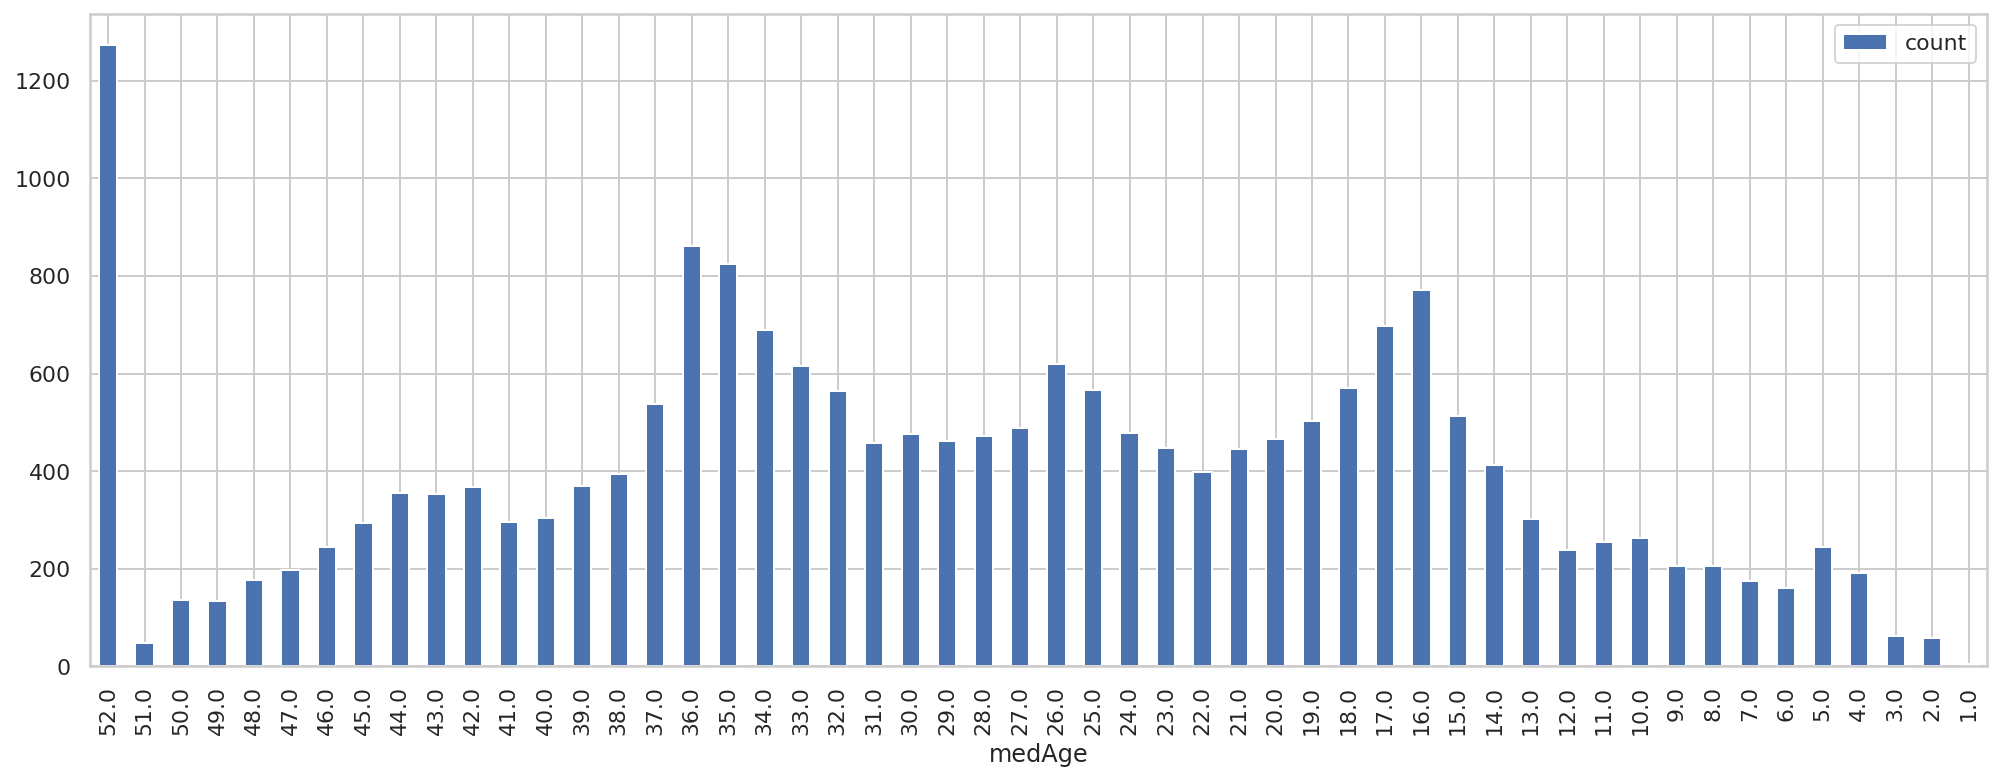

In [258]:
# plotando o gráfico da distribuição das idades das casas
age_mean.toPandas().plot.bar(x='medAge', 
                                figsize=(17, 6));

> A idades das casas apresenta uma longa distribuição e, grande parte está entre 15 e 40 anos. Há um montante considerável de casas com idade de 52 anos de construção.

Intuitivamente podemos dizer que, o local esteja passando por uma transformação onde, casas antigas está sendo demolidas e novas construídas e/ou a região nas últimas décadas sofreu uma expansão demográfica.

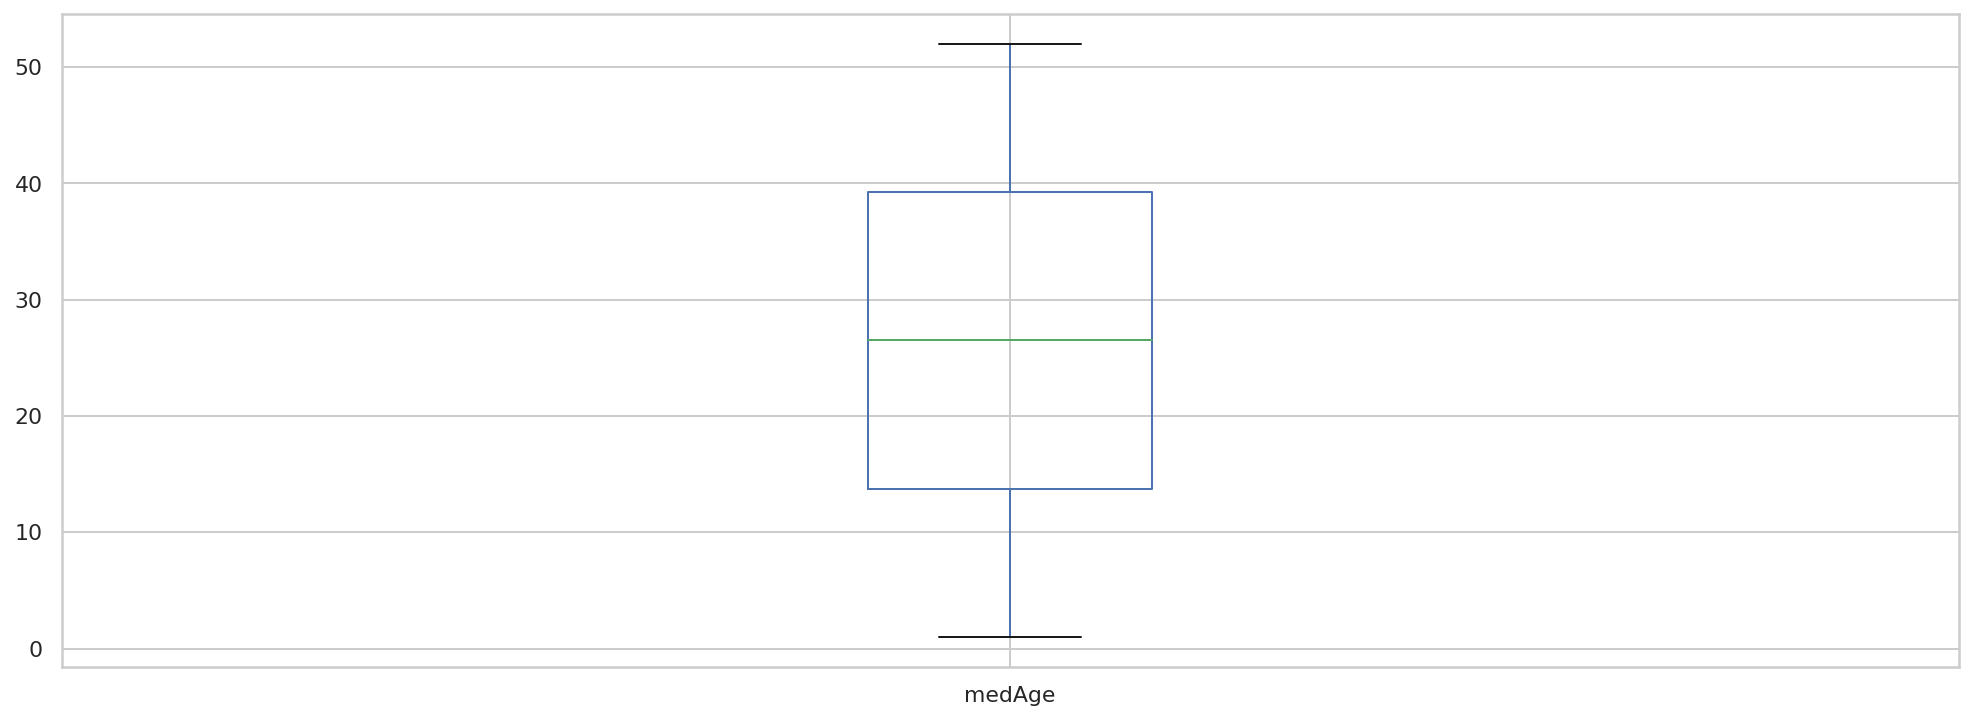

In [260]:
# plotando o gráfico boxplot das distribuições das idades das casas
age_mean.toPandas().plot.box(y='medAge', 
                                figsize=(17, 6));

### **7. Dados estatísticos**

Spark DataFrames inclui algumas funções integradas para processamento estatístico. A função `.describe()` executa cálculos de estatísticas resumidas em todas as colunas numéricas e os retorna como um DataFrame.

In [261]:
# estatísticas descritivas
housing_df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|               long|              lat|            medAge|            totRms|        totBedRms|               pop|         housHlds|            medInc|           medHval|
+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|            20640|             20640|            20640|             20640|             20640|
|   mean|-119.56970444871473|35.63186143109965|28.639486434108527|2635.7630813953488|537.8980135658915|1425.4767441860465|499.5396802325581|3.8706710030346416|206855.81690891474|
| stddev|  2.003531742932898|2.135952380602968| 12.58555761211163|2181.6152515827944| 421.247905943133|  

In [262]:
# criando uma seleção das colunas de interesse e visualizando suas estatísticas
(housing_df.describe().select(
    'summary',
    F.round('medAge', 4).alias('med_age'),
    F.round('totRms', 4).alias('tot_rms'),
    F.round('totBedRms', 4).alias('tot_bed_rms'),
    F.round('pop', 4).alias('pop'),
    F.round('housHlds', 4).alias('house_holds'),
    F.round('medInc', 4).alias('med_income'),
    F.round('medHval', 4).alias('med_house_val')).show())

+-------+-------+---------+-----------+---------+-----------+----------+-------------+
|summary|med_age|  tot_rms|tot_bed_rms|      pop|house_holds|med_income|med_house_val|
+-------+-------+---------+-----------+---------+-----------+----------+-------------+
|  count|20640.0|  20640.0|    20640.0|  20640.0|    20640.0|   20640.0|      20640.0|
|   mean|28.6395|2635.7631|    537.898|1425.4767|   499.5397|    3.8707|  206855.8169|
| stddev|12.5856|2181.6153|   421.2479|1132.4621|   382.3298|    1.8998|  115395.6159|
|    min|    1.0|      2.0|        1.0|      3.0|        1.0|    0.4999|      14999.0|
|    max|   52.0|  39320.0|     6445.0|  35682.0|     6082.0|   15.0001|     500001.0|
+-------+-------+---------+-----------+---------+-----------+----------+-------------+



> Observe os valores mínimo e máximo de todos os atributos (numéricos). Vemos que vários atributos têm uma ampla gama de valores: precisaremos normalizar seu conjunto de dados.

In [263]:
# criando uma seleção das variáveis de interesse 
distr_values = (housing_df.describe().select(
    F.round('medAge', 4).alias('med_age'),
    F.round('totRms', 4).alias('tot_rms'),
    F.round('totBedRms', 4).alias('tot_bed_rms'),
    F.round('pop', 4).alias('pop'),
    F.round('housHlds', 4).alias('house_holds'),
    F.round('medInc', 4).alias('med_income'),
    F.round('medHval', 4).alias('med_house_val')))

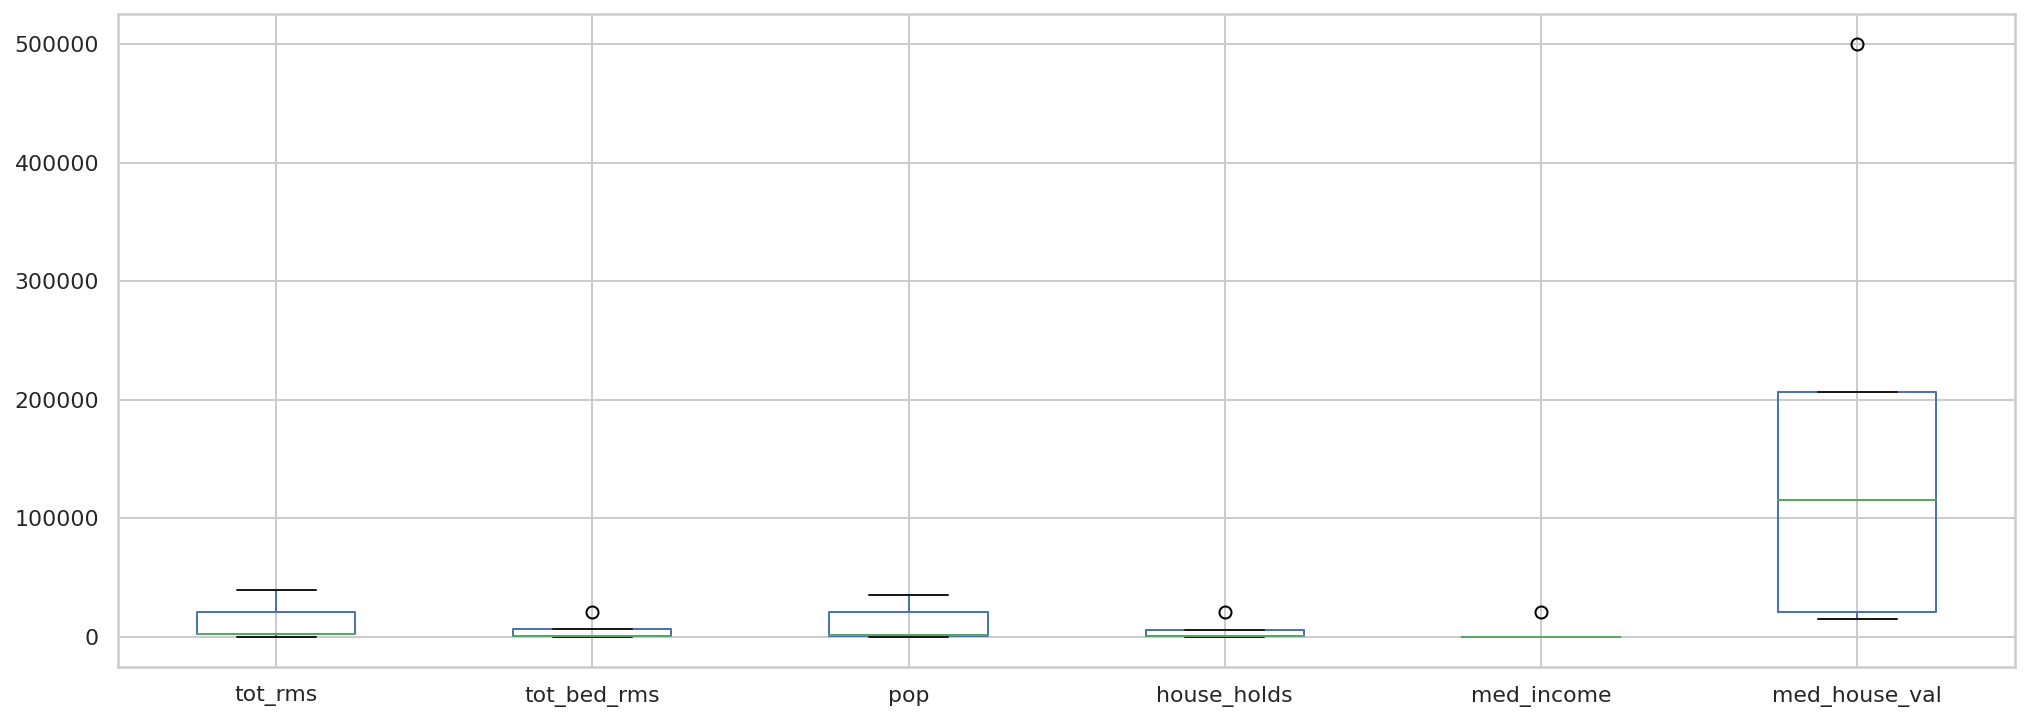

In [264]:
# plotando o gráfico boxplot das distribuições das variáveis instanciadad acima
distr_values.toPandas().plot.box(x='med_age', 
                                figsize=(17, 6));

### **8. Pré-processamento dos dados**

Com todas essas informações que coletamos em nossa pequena análise exploratória de dados, sabemos o suficiente para pré-processar nossos dados e alimentá-los para o modelo.

- não devemos nos preocupar com valores ausentes; todos os valores zero foram excluídos do conjunto de dados.
- provavelmente deveríamos padronizar nossos dados, pois vimos que a faixa de valores mínimo e máximo é bastante grande.
- existem possivelmente alguns atributos adicionais que poderíamos adicionar, como um recurso que registra o número de quartos por cômodo ou os cômodos por residência.
- nossa variável dependente também é muito grande; Para tornar nossa vida mais fácil, teremos que ajustar ligeiramente os valores.

#### **8.1 Pré-processamento dos valores `alvo`** 

> Primeiro, vamos começar com _medianHouseValue_, nossa variável dependente. Para facilitar nosso trabalho com os valores-alvo, expressaremos os valores da casa em unidades de 100.000. Isso significa que uma meta como 452600,000000 deve se tornar 4.526:

In [265]:
# antes do pré-processamento irei criar uma cópia dos dados
# para que, o tratamento não sobreescreva os dados originais
housing_df_copy = housing_df

In [266]:
# visualizando o nome das colunas da cópia do conjunto de dados
housing_df_copy.columns

['long',
 'lat',
 'medAge',
 'totRms',
 'totBedRms',
 'pop',
 'housHlds',
 'medInc',
 'medHval']

In [267]:
# ajustando os valores de "median_house_value"
housing_df_copy = housing_df_copy.withColumn('medHval', 
                                             col('medHval') / 100_000)

In [268]:
# visualizando as 2 primeiras linhas
housing_df_copy.show(2)

+-------+-----+------+------+---------+------+--------+------+-------+
|   long|  lat|medAge|totRms|totBedRms|   pop|housHlds|medInc|medHval|
+-------+-----+------+------+---------+------+--------+------+-------+
|-122.23|37.88|  41.0| 880.0|    129.0| 322.0|   126.0|8.3252|  4.526|
|-122.22|37.86|  21.0|7099.0|   1106.0|2401.0|  1138.0|8.3014|  3.585|
+-------+-----+------+------+---------+------+--------+------+-------+
only showing top 2 rows



> Podemos ver claramente que os valores foram ajustados corretamente quando olhamos para o resultado do método `.show()`.

### **9. Engenharia de recursos**

Agora que ajustamos os valores em `median_house_value`, iremos adicionar as seguintes colunas ao conjunto de dados:

- Cômodos por domicílio, que se refere ao número de cômodos dos domicílios por grupo de quarteirões;
- População por domicílio, o que basicamente nos dá uma indicação de quantas pessoas vivem em domicílios por grupo de quarteirões e,
- Quartos por cômodo que nos dará uma ideia de quantos cômodos são dormitórios por bloco.

Como estamos trabalhando com DataFrames, podemos usar melhor o método **select( )** para selecionar as colunas com as quais trabalharemos, ou seja, `total_rooms`, `households` e `population`. Além disso, temos que indicar que estamos trabalhando com colunas adicionando a função **col( )** ao nosso código. Caso contrário, não seremos capazes de fazer operações em elementos como a divisão que temos em mente para essas três variáveis.

In [269]:
# visualizando o nome das colunas
housing_df_copy.columns

['long',
 'lat',
 'medAge',
 'totRms',
 'totBedRms',
 'pop',
 'housHlds',
 'medInc',
 'medHval']

- **Dicionário:**
    - `rooms_per_household`: cômodos por domicílo;
    - `population_per_household`: população por domicílo e,
    - `bedrooms_per_room`: quartos por cômodo.

In [270]:
# adicionando novas colunas ao conjunto de dados conforme o dicionário acima
housing_df_copy = (housing_df_copy.withColumn('rmsPerHousHld', F.round(col('totRms') / col('housHlds'), 2))
                                  .withColumn('popPerHousHld', F.round(col('pop') / col('housHlds'), 2))
                                  .withColumn('bedRmsPerRm', F.round(col('totBedRms') / col('totRms'), 2)))

In [271]:
# visualizando o resultado
housing_df_copy.show(5)

+-------+-----+------+------+---------+------+--------+------+-------+-------------+-------------+-----------+
|   long|  lat|medAge|totRms|totBedRms|   pop|housHlds|medInc|medHval|rmsPerHousHld|popPerHousHld|bedRmsPerRm|
+-------+-----+------+------+---------+------+--------+------+-------+-------------+-------------+-----------+
|-122.23|37.88|  41.0| 880.0|    129.0| 322.0|   126.0|8.3252|  4.526|         6.98|         2.56|       0.15|
|-122.22|37.86|  21.0|7099.0|   1106.0|2401.0|  1138.0|8.3014|  3.585|         6.24|         2.11|       0.16|
|-122.24|37.85|  52.0|1467.0|    190.0| 496.0|   177.0|7.2574|  3.521|         8.29|          2.8|       0.13|
|-122.25|37.85|  52.0|1274.0|    235.0| 558.0|   219.0|5.6431|  3.413|         5.82|         2.55|       0.18|
|-122.25|37.85|  52.0|1627.0|    280.0| 565.0|   259.0|3.8462|  3.422|         6.28|         2.18|       0.17|
+-------+-----+------+------+---------+------+--------+------+-------+-------------+-------------+-----------+
o

> Podemos ver que, para a primeira linha, existem cerca de 6,98 cômodos por domicílio, os domicílios do bloco são cerca de 2,5 pessoas e a quantidade de dormitórios é bastante baixa com 0,15.

In [272]:
# visualizando o tipo de dado das colunas
housing_df_copy.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medAge: float (nullable = true)
 |-- totRms: float (nullable = true)
 |-- totBedRms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- housHlds: float (nullable = true)
 |-- medInc: float (nullable = true)
 |-- medHval: double (nullable = true)
 |-- rmsPerHousHld: double (nullable = true)
 |-- popPerHousHld: double (nullable = true)
 |-- bedRmsPerRm: double (nullable = true)



Como não queremos necessariamente padronizar nossos valores alvo, queremos ter certeza de isolá-los em nosso conjunto de dados. Observe também que este é o momento de deixar de fora as variáveis ​​que podemos não querer considerar em nossa análise. Nesse caso, vamos deixar de fora variáveis ​​como `longitude`, `latitude`, `housing_median_age` e `total_rooms`.

Neste caso, usaremos o método **select()** e passaremos os nomes das colunas na ordem que for mais apropriada. Nesse caso, a variável de destino `median_house_value` é colocada em primeiro lugar, para que não seja afetada pela padronização.

In [273]:
# reordenando e selecionando as colunas 
housing_df_copy = housing_df_copy.select('medHval',
                                         'totBedRms', 
                                         'pop', 
                                         'housHlds', 
                                         'medInc',
                                         'rmsPerHousHld', 
                                         'popPerHousHld',
                                         'bedRmsPerRm')

#### **9.1 Extração de Característica**

Agora que reordenamos os dados, estamos prontos para normalizar os dados. Vamos escolher os recursos a serem normalizados.

In [274]:
# selecionando os recursos
feature_cols = ['totBedRms', 'pop', 'housHlds', 'medInc', 
                'rmsPerHousHld', 'popPerHousHld', 'bedRmsPerRm']

**Usaremos o `VectorAssembler` para colocar recursos em uma coluna de vetor de recursos**.

In [275]:
# colocando os recursos em uma coluna de vetor
assembler = VectorAssembler(inputCols=feature_cols, 
                            outputCol='features')

In [276]:
# realizando a transformação no conjunto de dados e instanciando na variável "assembler_df"
assembled_df = assembler.transform(housing_df_copy)

In [277]:
# tamanho dos conjuntos de dados
assembled_df.count(), housing_df_copy.count()

(20640, 20640)

In [278]:
# visualizando a nova variável
# usando com argumento a função "truncate=False"
assembled_df.show(10, truncate=False)

+-------+---------+------+--------+------+-------------+-------------+-----------+-------------------------------------------------------+
|medHval|totBedRms|pop   |housHlds|medInc|rmsPerHousHld|popPerHousHld|bedRmsPerRm|features                                               |
+-------+---------+------+--------+------+-------------+-------------+-----------+-------------------------------------------------------+
|4.526  |129.0    |322.0 |126.0   |8.3252|6.98         |2.56         |0.15       |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585  |1106.0   |2401.0|1138.0  |8.3014|6.24         |2.11         |0.16       |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521  |190.0    |496.0 |177.0   |7.2574|8.29         |2.8          |0.13       |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413  |235.0    |558.0 |219.0   |5.6431|5.82         |2.55         |0.18       |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422  |280.0    |565.0 |2

In [279]:
# visualizando o novo recurso (features) criado
# usando com argumento a função "truncate=False"
assembled_df.select('features').show(10, truncate=False)

+-------------------------------------------------------+
|features                                               |
+-------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |
|[213.0,413.0,193.0,4.036799907684326,4.76,2.14,0.23]   |
|[489.0,1094.0,514.0,3.65910005569458,4.93,2.13,0.19]   |
|[687.0,1157.0,647.0,3.119999885559082,4.8,1.79,0.22]   |
|[665.0,1206.0,595.0,2.080399990081787,4.29,2.03,0.26]  |
|[707.0,1551.0,714.0,3.691200017929077,4.97,2.17,0.2]   |
+-------------------------------------------------------+
only showing top 10 rows



In [280]:
# visualizando o tipo de dado das colunas
assembled_df.printSchema()

root
 |-- medHval: double (nullable = true)
 |-- totBedRms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- housHlds: float (nullable = true)
 |-- medInc: float (nullable = true)
 |-- rmsPerHousHld: double (nullable = true)
 |-- popPerHousHld: double (nullable = true)
 |-- bedRmsPerRm: double (nullable = true)
 |-- features: vector (nullable = true)



> Todos os recursos (**features**) foram transformados em um `Dense Vector`.

### **10. Estandardização**
Em seguida, podemos finalmente dimensionar os dados usando `StandardScaler`. As colunas de entrada são os recursos, e a coluna de saída com o redimensionado que será incluída no **scaled_df** será chamada de `"features_scaled"`.

In [281]:
# iniciando o "StandardScaler"
std_scaler = StandardScaler(inputCol='features', 
                            outputCol='features_scaled')

# visualizando o objeto criado
std_scaler

StandardScaler_001e06c67535

In [282]:
# aplicando o treinamento e a transformação com o modelo instanciando acima
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [283]:
# visualizando o resultado do escalamento dos dados
scaled_df.select('features', 'features_scaled').show(10, 
                                                     truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

### **11. Construindo um modelo de aprendizado de máquina com Spark ML**

Com todo o pré-processamento feito, finalmente é hora de começar a construir nosso modelo de regressão linear.

Como sempre, primeiro precisamos dividir os dados em _conjuntos de treinamento e teste_. Felizmente, isso não é problema, pois temos o método `randomSplit()`.

In [284]:
# realizando o particionamento dos dados em treino e teste
train_data, test_data = scaled_df.randomSplit([0.8, 0.2],   # dividindo os dados em 80% para treino e os demais 20% para teste
                                              seed = rnd_seed)

> Passamos uma lista com dois números que representam o tamanho que queremos que seus conjuntos de treinamento e teste tenham e uma semente (que foi declarada o valor no início do estudo), que é necessária por motivos de reprodutibilidade.

**Observe:** que o argumento `elasticNetParam` corresponde a `αα` ou a _interceptação vertical_ e que o `regParam` ou o _parâmetro de regularização_ corresponde a `λλ`.

In [285]:
# visualizando as colunas dos dados de treino
train_data.columns

['medHval',
 'totBedRms',
 'pop',
 'housHlds',
 'medInc',
 'rmsPerHousHld',
 'popPerHousHld',
 'bedRmsPerRm',
 'features',
 'features_scaled']

> Perceba que, a coluna alvo - `medHval`, que representa o valor médio das casas - não se encontra presente nos dados de treino, isso é muito importante para o processo de treinamento do modelo.

Pois o modelo tem como principal missão, é predizer a variável alvo dados alguns atributos como entrada e, assim podermos mensurar a capacidade de acurácia e outras métricas de avaliação do modelo.

**Criando um modelo `ElasticNet`.**

> O _ElasticNet_ é um modelo de regressão linear treinado com `L1` e `L2` antes como regularizador. Esta combinação permite aprender um modelo esparso onde poucos dos pesos são diferentes de zero como **Lasso**, enquanto ainda mantém as propriedades de regularização de **Ridge**. Controlamos a combinação convexa de L1 e L2 usando o parâmetro `l1_ratio`.

_Elastic-net_ é útil quando há vários recursos correlacionados entre si. `Lasso` provavelmente escolherá um desses aleatoriamente, enquanto elástico-net provavelmente escolherá ambos.

Uma vantagem prática da troca entre _Lasso_ e _Ridge_ é que permite que a **Elastic-Net** herde um pouco da estabilidade de `Ridge` sob rotação. A função objetivo a minimizar é neste caso:

\begin{align}
min_w\frac{1}{2n_{samples}}{\parallel{X_w - y}\parallel}^2_2 + \alpha\lambda{\parallel{X_w - y}\parallel}_1 + \frac{\alpha(1-\lambda)}{2}{\parallel{w}\parallel}^2_2
\end{align}

- http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [286]:
# instanciando o modelo
linReg = (LinearRegression(featuresCol = 'features_scaled', labelCol = 'medHval', 
                            predictionCol = 'predMedHval', maxIter = 10, regParam = 0.3, 
                            elasticNetParam = 0.8, standardization = False))

In [287]:
# treinando o modelo com os dados de treinamento
linearModel = linReg.fit(train_data)

### **12. Avaliando o modelo**

Com nosso modelo implementado, podemos gerar previsões para nossos dados de teste: use o método `transform()` para prever os rótulos de nossos _test_data_. 

Então, podemos usar operações **RDD** para extrair as previsões, bem como os rótulos verdadeiros do _DataFrame_.

#### **12.1. Visualizando os coeficientes do modelo**


In [288]:
# visualizando os coeficientes do modelo
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [290]:
# visualizando o nome dos atributos
print(feature_cols)

['totBedRms', 'pop', 'housHlds', 'medInc', 'rmsPerHousHld', 'popPerHousHld', 'bedRmsPerRm']


In [291]:
# visualizando o intercepto do modelo
linearModel.intercept

1.0013833516596085

In [304]:
# criando um daframe com o interceptos - features) - e os coeficientes das respectivas features
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_cols,
    'Co-efficients': np.insert(linearModel.coefficients.toArray(), 
                               0, linearModel.intercept)
})

In [306]:
# selecionando somente as colunas do dataframe criado - "Feature" e "Co-efficients" e exibindo-as
coef_df = coef_df[['Feature', 'Co-efficients']]
coef_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totBedRms,0.000000
2,pop,0.000000
3,housHlds,0.000000
4,medInc,0.526157
5,rmsPerHousHld,0.000000
6,popPerHousHld,0.000000
7,bedRmsPerRm,0.000000


#### **12.2. Gerando as previsões**

In [307]:
# gerando as predições
predictions = linearModel.transform(test_data)

In [308]:
# extraindo as predições e os rótulos corretos "conhecidos"
predAndLabels = predictions.select('predMedHval', 'medHval')

In [309]:
# visualizando a comparação - rótulos preditos VS rótulos conhecidos
predAndLabels.show()

+------------------+-------+
|       predMedHval|medHval|
+------------------+-------+
|  1.14982901467337|0.14999|
|1.3037582901805782|  0.225|
| 1.752972574315186|  0.225|
|1.6094289295308724|  0.269|
|1.5956645319495768|  0.344|
|1.2917940087238426|  0.367|
|1.8668547795751218|  0.375|
| 1.369423339785637|  0.394|
|1.5305533439120043|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043998|  0.417|
| 1.229923204690587|  0.425|
|1.4841640700933143|  0.425|
|1.3510338217435218|   0.43|
|1.2619110212709588|  0.436|
|1.3350814464678744|   0.44|
|1.4832778453641755|   0.44|
|1.4337313361080328|  0.444|
|1.3691187093204966|  0.445|
|  1.47521855868216|  0.446|
+------------------+-------+
only showing top 20 rows



#### **12.3. Inspecionando as métricas**

Olhar para os valores previstos é uma coisa, mas outra e melhor coisa é olhar algumas métricas para ter uma ideia melhor de quão bom realmente é o seu modelo.

Use o atributo:
    
    LinearRegressionModel.summary.


Em seguida, também podemos usar o atributo summary para obter o `rootMeanSquaredError` e o `r2`.

In [310]:
# visualizando o RMSE - a raiz do erro médio quadrático
print(f'RMSE: {linearModel.summary.rootMeanSquaredError}')

RMSE: 0.8819852045268861


> **O que é a raiz do erro médio quadrático (RMSE)?**

O `RMSE` (_raiz do erro médio quadrático_) é a raiz do _erro quadrático médio_ - `MSE`, que é a média do quadrado dos erros. 

Quanto maior for o número, maior será o erro. Erro neste caso significa a diferença entre os valores observados y1, y2, y3,... e os previstos pred (y1), pred (y2), pred (y3),... 

Nós elevamos ao quadrado cada diferença (pred (yn) - yn) ) ** 2 para que os valores negativos e positivos não se cancelem.

In [311]:
# visualizando o MAE - erro médio absoluto
print(f'MAE: {linearModel.summary.meanAbsoluteError}')

MAE: 0.6782895319917991


> **O que é erro médio absoluto (MAE)?**

O `MAE` (erro médio absoluto) é subtração do valor previsto do valor real.

    Erro de previsão → Valor real - valor previsto

Este erro de previsão é obtido para cada registro, após o qual convertemos todos os erros em positivos e, em seguida somando-os e extraindo a sua média.

In [312]:
# visualizando o R2 - coeficiente de determinação
print(f'R2: {linearModel.summary.r2}')

R2: 0.4180854895364573


> **O que é o coeficiente de determinação (R2)?**

A pontuação de `R2` é uma métrica muito importante usada para avaliar o desempenho de um modelo de aprendizado de máquina baseado em regressão. É pronunciado como R ao quadrado e também é conhecido como coeficiente de determinação. 

Ele funciona medindo a quantidade de variação nas previsões explicadas pelo conjunto de dados. Simplificando, é a diferença entre as amostras no conjunto de dados e as previsões feitas pelo modelo.

**Resumidamente podemos dizer...**

- O `RMSE` mede quanto erro existe entre dois conjuntos de dados comparando um valor previsto e um valor observado ou conhecido. Quanto menor for um valor RMSE, mais próximos os valores preditos e observados estão.

- O `R2` ("R ao quadrado") ou o coeficiente de determinação é uma medida que mostra quão próximos os dados estão da linha de regressão ajustada. Esta pontuação estará sempre entre 0 e 100% (ou 0 a 1 neste caso), onde 0% indica que o modelo não explica nada da variabilidade dos dados de resposta em torno de sua média, e 100% indica o contrário: explica toda a variabilidade. Isso significa que, em geral, quanto maior o R ​​quadrado, melhor o modelo se ajusta aos nossos dados.

**Usando o `RegressionEvaluator` do pacote _pyspark.ml_**

In [322]:
# instanciando o avaliador do RMSE
evaluator = RegressionEvaluator(predictionCol = 'predMedHval', 
                                labelCol = 'medHval', 
                                metricName = 'rmse')

# visualizando o resultado
print(f'RMSE: {(evaluator.evaluate(predAndLabels))}')

RMSE: 0.8677342923034236


In [324]:
# instanciando o avaliador do MAE
evaluator = RegressionEvaluator(predictionCol = 'predMedHval', 
                                labelCol = 'medHval', 
                                metricName = 'mae')

# visualizando o resultado
print(f'MAE: {(evaluator.evaluate(predAndLabels))}')

MAE: 0.6736097745764633


In [325]:
# instanciando o avaliador do R2
evaluator = RegressionEvaluator(predictionCol = 'predMedHval', 
                                labelCol = 'medHval', 
                                metricName = 'r2')

# visualizando o resultado
print(f'R2: {(evaluator.evaluate(predAndLabels))}')

R2: 0.42517112885139363


**Usando o `RegressionMetrics` do pacote _pyspark.mllib_**

In [327]:
# mllib é antigo, então os métodos estão disponíveis em rdd
metrics = RegressionMetrics(predAndLabels.rdd)

In [328]:
# visualizando o resultado das métricas
print(f'RMSE: {(metrics.rootMeanSquaredError)}')
print(f'MAE: {(metrics.meanAbsoluteError)}')
print(f'R2: {(metrics.r2)}')

RMSE: 0.8677342923034236
MAE: 0.6736097745764633
R2: 0.42517112885139363


Definitivamente, há algumas melhorias necessárias em nosso modelo! 

Se quisermos continuar com este modelo, podemos modificar os parâmetros que passamos para o modelo, e as variáveis ​​que incluímos em seu DataFrame original.

Por enquanto é isso!!!

In [329]:
# encerrando a sessão spark
spark.stop()

Até mais!!  ; )